### Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product

### Config

In [2]:
DATA_FILE_PATHS = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/input/'

OUTPUT_PATH_LABELING = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/label/label_p2.parquet'
OUTPUT_PATH_FEAT = '/workspace/rahnemacollege/Project/Git/demand-prediction/data/label/feat_p2.parquet'

start_date = '2023-01-01'
end_date = '2023-05-01'

### Load data

In [3]:
def load_data(file_paths, start_date=None, end_date=None):
    df = pd.read_parquet(file_paths)
    df['date'] = df['tpep_pickup_datetime'].dt.date.astype(str)

    if start_date:
        if end_date:
            df = df[(df['date'] >= start_date) & (
                df['date'] < end_date)]
        else:
            df = df[df['date'] > start_date].reset_index(drop=True)
    # Sort the DataFrame based on the 'tpep_pickup_datetime' column in ascending order
    df = df.sort_values(by='date')
    df = df.reset_index(drop=True)

    # Calculate the start time of each interval
    df['interval_start'] = df['tpep_pickup_datetime'].dt.floor('3H')

    # Calculate the end time of each interval
    df['interval_end'] = df['interval_start'] + pd.Timedelta(hours=3)

    # Create a new column with the time interval in the desired format
    df['time_interval'] = df['interval_start'].dt.strftime(
        '%H:%M:%S') + ' - ' + df['interval_end'].dt.strftime('%H:%M:%S')

    # Drop 'interval_start' and 'interval_end' columns
    df.drop(columns=['interval_start', 'interval_end'], inplace=True)

    # Create bins for interval numbers from 1 to 8
    df['time_interval_number'] = pd.cut(
        df['tpep_pickup_datetime'].dt.hour, bins=8, labels=range(1, 9), right=False)

    return df


rides_df = load_data(DATA_FILE_PATHS, start_date, end_date)
print(rides_df.shape)
rides_df.head()

(12672629, 22)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,time_interval,time_interval_number
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.5,0.00,0.00,1.0,14.30,2.5,0.00,2023-01-01,00:00:00 - 03:00:00,1
1,1,2023-01-01 16:18:55,2023-01-01 16:26:09,3.0,0.00,1.0,N,107,90,1,...,0.5,2.10,0.00,1.0,12.60,2.5,0.00,2023-01-01,15:00:00 - 18:00:00,6
2,2,2023-01-01 16:59:08,2023-01-01 17:41:59,1.0,19.82,2.0,N,132,238,1,...,0.5,16.36,6.55,1.0,98.16,2.5,1.25,2023-01-01,15:00:00 - 18:00:00,6
3,2,2023-01-01 16:29:59,2023-01-01 16:59:01,1.0,9.36,1.0,N,138,68,1,...,0.5,11.80,6.55,1.0,70.80,2.5,1.25,2023-01-01,15:00:00 - 18:00:00,6
4,2,2023-01-01 16:35:44,2023-01-01 16:53:56,2.0,3.18,1.0,N,114,162,1,...,0.5,4.76,0.00,1.0,28.56,2.5,0.00,2023-01-01,15:00:00 - 18:00:00,6


## Labeling

### Aggregate data and labeling

In [4]:
def labeling_by_day(rides_df: pd.DataFrame):
    aggregated_df = rides_df.groupby(
        ['date', 'PULocationID']).size().reset_index(name='count')
    unique_dates = rides_df['date'].unique()
    unique_pu_location_ids = rides_df['PULocationID'].unique()
    all_combinations = list(product(unique_dates, unique_pu_location_ids))
    combinations_df = pd.DataFrame(all_combinations, columns=[
                                   'date', 'PULocationID'])
    label_df = aggregated_df.merge(combinations_df, how='right', on=[
                                   'date', 'PULocationID']).fillna(0)
    return label_df


def labeling_by_interval(rides_df: pd.DataFrame):
    aggregated_df = rides_df.groupby(
        ['date', 'time_interval_number', 'PULocationID']).size().reset_index(name='count')
    unique_dates = rides_df['date'].unique()
    unique_interval = rides_df['time_interval_number'].unique()
    unique_pu_location_ids = rides_df['PULocationID'].unique()
    all_combinations = list(
        product(unique_dates, unique_interval, unique_pu_location_ids))
    combinations_df = pd.DataFrame(all_combinations, columns=[
                                   'date', 'time_interval_number', 'PULocationID'])
    label_df = aggregated_df.merge(combinations_df, how='right', on=[
                                   'date', 'time_interval_number', 'PULocationID']).fillna(0)
    # Sort based on two columns: 'time_interval_number' (ascending) and 'date' (ascending)
    label_df = label_df.sort_values(
        by=['date', 'time_interval_number'], ascending=[True, True])
    return label_df

In [5]:
labels_day_df = labeling_by_day(rides_df)
print(labels_day_df.shape)
labels_day_df.head()

(31440, 3)


,date,PULocationID,count
0,2023-01-01,161,2370.0
1,2023-01-01,107,2015.0
2,2023-01-01,132,5582.0
3,2023-01-01,138,2440.0
4,2023-01-01,114,878.0


In [6]:
labels_time_df = labeling_by_interval(rides_df)
print(labels_time_df.shape)
labels_time_df.head()

(251520, 4)


,date,time_interval_number,PULocationID,count
0,2023-01-01,1,161,504
1,2023-01-01,1,107,604
2,2023-01-01,1,132,389
3,2023-01-01,1,138,42
4,2023-01-01,1,114,205


### Plot Histrogram Between Daily and Time Interval Data

In [7]:
def dist_dayVStime(df1: pd.DataFrame, df2: pd.DataFrame, start_range_demand: int, end_range_demand: int):
    plt.figure(figsize=(10, 7.5))

    sns.histplot(data=df2,
                 x='count',
                 alpha=0.75,
                 bins=15,
                 binrange=(start_range_demand, end_range_demand),
                 multiple='dodge',
                 color='skyblue',
                 label='Labeling by Time Interval')

    sns.histplot(data=df1,
                 x='count',
                 alpha=0.5,
                 bins=15,
                 binrange=(start_range_demand, end_range_demand),
                 multiple='dodge',
                 color='orange',
                 label='Labeling by Day')

    plt.title('Histogram Of Distribution')
    plt.xlabel('Counts')
    plt.ylabel('Frequency')
    plt.title('Comparison of Count Values')
    plt.legend()
    plt.show()

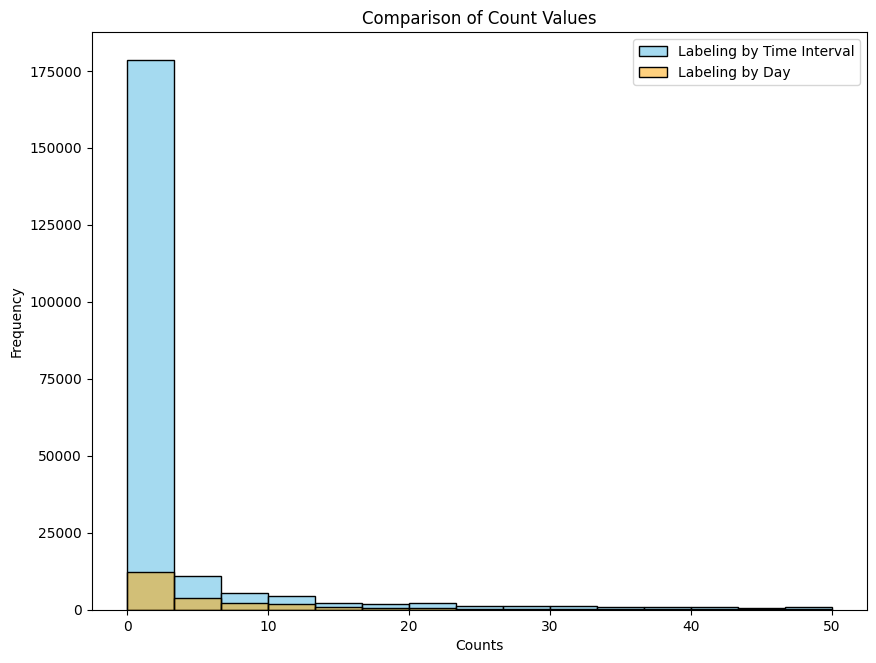

In [8]:
dist_dayVStime(labels_day_df, labels_time_df, 0, 50)

### Save labeling data

In [9]:
labels_time_df.to_parquet(OUTPUT_PATH_LABELING)

## Feature Selection

### Add calender and previous demands features

In [10]:
def adding_feature(rides_df: pd.DataFrame):
    rides_df['date'] = rides_df['date'].astype('datetime64[ns]')
    rides_df['PU_day_of_month'] = rides_df['date'].dt.day.astype(np.uint8)
    rides_df['PU_day_of_week'] = rides_df['date'].dt.weekday.astype(np.uint8)
    rides_df = rides_df.sort_values(
        ['PULocationID', 'date', 'time_interval_number'])
    rides_df['last_interval_demand'] = rides_df.groupby(['PULocationID'])[
        'count'].shift(1)
    rides_df['last_day_demand'] = rides_df.groupby(['PULocationID'])[
        'count'].shift(8)
    rides_df['last_week_demand'] = rides_df.groupby(['PULocationID'])[
        'count'].shift(56)

    return rides_df


labels_time_df_feat = adding_feature(labels_time_df)
print(labels_time_df_feat.shape)
labels_time_df_feat.head()

(251520, 9)


,date,time_interval_number,PULocationID,count,PU_day_of_month,PU_day_of_week,last_interval_demand,last_day_demand,last_week_demand
58,2023-01-01,1,1,0,1,6,NaN,NaN,NaN
1368,2023-01-01,2,1,1,1,6,0.0,NaN,NaN
1630,2023-01-01,3,1,1,1,6,1.0,NaN,NaN
1892,2023-01-01,4,1,1,1,6,1.0,NaN,NaN
844,2023-01-01,5,1,13,1,6,1.0,NaN,NaN


### Save features engineering  data

In [11]:
labels_time_df_feat.to_parquet(OUTPUT_PATH_FEAT)